In [919]:
import re
import pandas as pd
import numpy as np
from collections import defaultdict

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold

In [920]:
import importlib
import datasets
importlib.reload(datasets)
from datasets import load_credit_score, load_term_deposits

In [953]:
(X_train, y_train), (X_test, y_test) = load_credit_score()

/Users/vinit/miniforge3/envs/main/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3251: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


In [954]:
from sklearn.decomposition import PCA
pca = PCA()
X_pca = pca.fit_transform(X_train)

/Users/vinit/miniforge3/envs/main/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3251: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


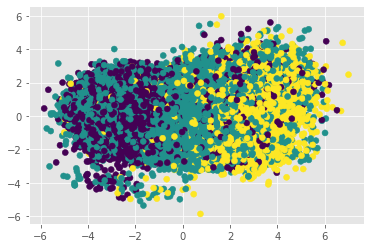

In [965]:
(X_train, y_train), (X_test, y_test) = load_credit_score()

pca = PCA()
X_pca = pca.fit_transform(X_train)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train);

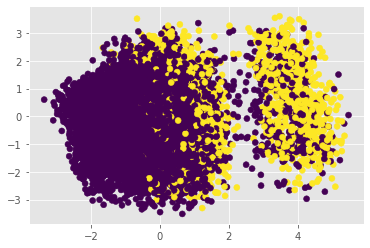

In [964]:
(X_train, y_train), (X_test, y_test) = load_term_deposits()

pca = PCA()
X_pca = pca.fit_transform(X_train)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train);

In [921]:
y_train.mean()

0.11217754172989378

In [922]:
(X_train, y_train), (X_test, y_test) = load_term_deposits()

In [923]:
import evaluate
importlib.reload(evaluate)

def grid_search(model_cls, grid={}, **kwargs):
    if len(kwargs) == len(grid):
        model_fn = evaluate.create_model_fn(model_cls, grid)
        metrics = evaluate.cross_validate(X_train, y_train, model_fn)
        metrics.update(grid)
        return [metrics]

    for arg in kwargs:
        if arg in grid: continue
        break
    
    out = []
    for value in kwargs[arg]:
        new = dict(grid)
        new[arg] = value
        out.extend(grid_search(model_cls, new, **kwargs))
    return out

In [924]:
# n_neighbors = [8, 16, 32, 64, 128, 256, 512, 1024, 2048]
# weights = ['uniform', 'distance']

# readings = pd.DataFrame(grid_search(
#     [0.84, 0.16], 
#     KNeighborsClassifier, 
#     n_neighbors=n_neighbors,
#     weights=weights,
# ))

In [875]:
from sklearn.ensemble import AdaBoostClassifier, HistGradientBoostingClassifier

cla = HistGradientBoostingClassifier(
#     max_depth=4,
    min_samples_leaf=64,
    l2_regularization=0.3,
    validation_fraction=0.2,
    learning_rate=0.05,
#     n_estimators=100,
#     base_estimator=DecisionTreeClassifier(max_depth=1)
)

In [876]:
cla.fit(X_train, y_train)

HistGradientBoostingClassifier(l2_regularization=0.3, learning_rate=0.05,
                               min_samples_leaf=64, validation_fraction=0.2)

In [877]:
evaluate.get_metrics(y_test, cla.predict_proba(X_test))

{'Accuracy': 0.9095599393019727,
 'AUROC': 0.9259798997826544,
 'AUPRC': 0.7929160734186895}

In [891]:
boosting_readings = pd.DataFrame(grid_search(
    HistGradientBoostingClassifier,
    min_samples_leaf=[2, 4, 8, 16, 32],
    max_depth=[8, 16, 32, 64],
    l2_regularization=[0.35],
    learning_rate=[0.035],
))

5it [00:07,  1.46s/it]
5it [00:07,  1.56s/it]
5it [00:06,  1.40s/it]
5it [00:06,  1.23s/it]


In [893]:
# dtree_readings = pd.DataFrame(grid_search(
#     DecisionTreeClassifier,
#     min_samples_leaf=[8, 16, 32, 64, 128, 256],
#     max_depth=[8, 16, 32, 64],
#     min_samples_split=[128, 256, 512],
#     criterion=['gini', 'entropy']
# ))
# dtree_readings.sort_values('AUPRC')

In [898]:
# svc_readings = pd.DataFrame(grid_search(
#     SVC,
#     kernel=['linear', 'poly', 'rbf', 'sigmoid'],
#     probability=[True],
# ))

In [967]:
dtree_readings.sort_values('AUPRC')

,Accuracy,AUROC,AUPRC,min_samples_leaf,max_depth,min_samples_split,criterion
121,0.897420,0.894703,0.756132,256,8,128,entropy
123,0.897420,0.894703,0.756132,256,8,256,entropy
125,0.897420,0.894703,0.756132,256,8,512,entropy
99,0.903225,0.896080,0.758509,128,8,256,entropy
97,0.903225,0.896110,0.758517,128,8,128,entropy
...,...,...,...,...,...,...,...
70,0.906904,0.913073,0.779384,32,64,512,gini
58,0.906904,0.914171,0.779637,32,16,512,gini
44,0.907587,0.910674,0.780583,16,64,256,gini
38,0.907587,0.910890,0.780648,16,32,256,gini


In [949]:

# clas = []
# for k in ['poly', 'rbf', 'sigmoid']:
#     print(k)
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
svm = SVC(kernel='rbf')
cla = CalibratedClassifierCV(svm) 
# cla = LinearSVC()
cla.fit(X_train, y_train)
cla.predict_proba(X_test)
print(evaluate.get_metrics(y_test, y_pred))
# clas.append(cla)

{'Accuracy': 0.8916540212443096, 'AUROC': 0.7871973759625914, 'AUPRC': 0.6710474034669829}


In [950]:
for cla in clas:
    y_pred = cla.predict_proba(X_test)
    print(evaluate.get_metrics(y_test, y_pred))0

{'Accuracy': 0.8916540212443096, 'AUROC': 0.7871973759625914, 'AUPRC': 0.6710474034669829}


In [894]:
boosting_readings.sort_values('AUPRC')

,Accuracy,AUROC,AUPRC,min_samples_leaf,l2_regularization,learning_rate
3,0.909788,0.928195,0.794035,16,0.35,0.035
2,0.909522,0.928383,0.794370,8,0.35,0.035
0,0.910167,0.928334,0.794684,2,0.35,0.035
1,0.909408,0.928384,0.794737,4,0.35,0.035


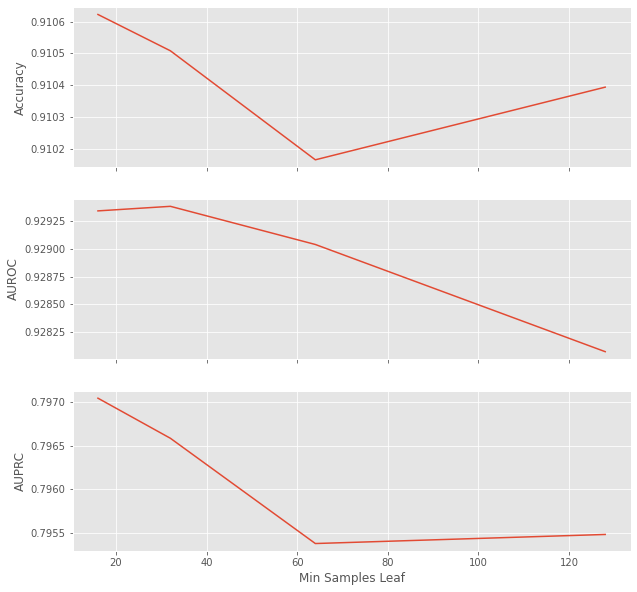

In [889]:
def plot(df, x, xlabel, grouping='<UNK>', log=True):

    fig, ax = plt.subplots(nrows=3, figsize=(10,10), sharex=True)
    ax[-1].set_xlabel(xlabel)

    r1 = dtree_readings
    if grouping == '<UNK>':
        df = df.copy()
        df[grouping] = 1
        
        
    for g in df[grouping].unique():
        r1 = df[df[grouping] == g]
        r1 = r1.groupby(x, as_index=False).max()
        ax[0].plot(r1[x], r1.Accuracy, label=g)
        ax[0].set_ylabel('Accuracy')
        ax[1].plot(r1[x], r1.AUROC, label=g)
        ax[1].set_ylabel('AUROC')
        ax[2].plot(r1[x], r1.AUPRC, label=g)
        ax[2].set_ylabel('AUPRC')
        if log:
            plt.xscale('log', basex=2);
        
    if grouping != '<UNK>':
        for a in ax:
            a.legend()
        
plot(boosting_readings, 'min_samples_leaf', 'Min Samples Leaf', log=False)

In [596]:
import matplotlib.pyplot as plt

/var/folders/p8/0wsy16q946lb_4prf1n0l93m0000gp/T/ipykernel_855/1179013558.py:17: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.xscale('log', basex=2);
/var/folders/p8/0wsy16q946lb_4prf1n0l93m0000gp/T/ipykernel_855/1179013558.py:17: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.xscale('log', basex=2);


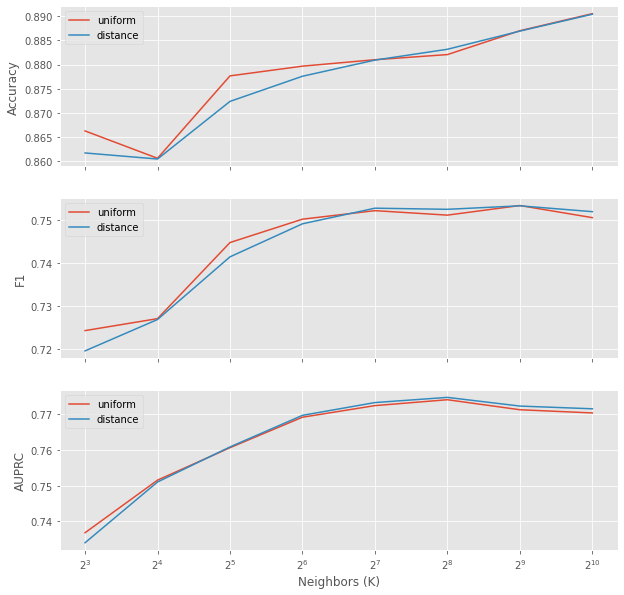

In [689]:
plot(readings, 'n_neighbors', 'Neighbors (K)', 'weights')

In [508]:
readings

,Accuracy,F1,AUPRC,x
0,0.878338,0.666831,0.699509,1
1,0.885053,0.713057,0.723090,5
2,0.887860,0.732064,0.741374,10
3,0.891464,0.744652,0.756692,25
4,0.893323,0.749057,0.765990,50
5,0.895068,0.750555,0.770618,75
6,0.895599,0.750639,0.771872,100
7,0.897003,0.751335,0.773391,150
8,0.896813,0.747659,0.773381,200
9,0.898027,0.749202,0.773717,250


In [373]:
df['y'] = df['y'].map({'yes': 1, 'no': 0}.get)

In [374]:
onehot_features = [
    'job', 'marital', 'education', 'default', 'housing', 'loan',
    'contact', 'month', 'day_of_week', 'poutcome'
]
numeric_features = [
    "age",
    "duration",
    "campaign",
    "pdays",
]

In [375]:
from sklearn.preprocessing import OneHotEncoder, PowerTransformer

onehot_encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)
power_transformer = PowerTransformer()

In [376]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=0)

In [377]:
onehot_encoder.fit(train_df[onehot_features])
power_transformer.fit(train_df[numeric_features])

PowerTransformer()

In [378]:
 def transform(df):
    x1 = onehot_encoder.transform(df[onehot_features])
    x3 = power_transformer.transform(df[numeric_features])
    x3[pd.isnull(x3)] = 0
    return np.concatenate([x1, x3], axis=1)

train = transform(train_df), train_df["y"]
test = transform(test_df), test_df["y"]

In [395]:
train_df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,y
26529,41,blue-collar,married,basic.4y,unknown,yes,no,cellular,apr,fri,359,1,999,0,nonexistent,0
28227,29,admin.,single,university.degree,unknown,no,no,cellular,aug,thu,112,1,999,0,nonexistent,0
27170,33,admin.,married,university.degree,unknown,no,no,cellular,aug,fri,204,1,999,0,nonexistent,0
5460,27,unemployed,single,high.school,no,no,no,cellular,aug,wed,93,1,4,3,success,0
3069,51,admin.,married,university.degree,unknown,yes,no,cellular,aug,tue,507,2,999,0,nonexistent,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20757,25,admin.,single,basic.9y,no,yes,yes,cellular,jul,thu,37,17,999,0,nonexistent,0
32103,52,blue-collar,married,basic.4y,unknown,no,yes,cellular,jul,fri,114,12,999,0,nonexistent,0
30403,56,blue-collar,married,basic.4y,no,yes,no,cellular,jul,thu,119,5,999,0,nonexistent,0
21243,42,housemaid,married,basic.4y,unknown,yes,no,telephone,jun,fri,408,5,999,0,nonexistent,0


In [379]:
test[1]

5379     0
13301    0
15089    0
8998     0
18820    0
        ..
22982    0
29248    0
28842    0
12856    0
27885    0
Name: y, Length: 6590, dtype: int64

In [380]:
cla = DecisionTreeClassifier()

cla.fit(*train)

DecisionTreeClassifier()

In [381]:
pred = cla.predict_proba(test[0])
label = pred.argmax(axis=1)

In [391]:
test[1].unique()

array([0, 1])

In [393]:
pr_auc_score(test[1], pred, average='macro')

0.7301985334901735

In [273]:
X = df[['distance_from_home', 'distance_from_last_transaction',
       'ratio_to_median_purchase_price', 'repeat_retailer', 'used_chip',
       'used_pin_number', 'online_order']]

y = df['fraud']

In [274]:
from sklearn.linear_model import LogisticRegression

In [350]:
(X_train, y_train), (X_test, y_test) = load_credit_score()

/Users/vinit/miniforge3/envs/main/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3251: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


In [351]:
cla = LogisticRegression()
cla.fit(X_train, y_train)

LogisticRegression()

In [352]:
from sklearn.tree import export_text

In [353]:

cla.score(X_test, y_test)

0.636

In [354]:
pr_auc_score(y_test, cla.predict_proba(X_test))

0.6445887157591524

In [355]:
f1_score(y_test, cla.predict(X_test), average='macro')

0.6062927901513105

In [269]:
model_fn = create_model_fn(GradientBoostingClassifier, {'max_leaf_nodes': 100, 'n_estimators': 10})
cross_validate(X_train, y_train, model_fn)

5it [00:29,  5.89s/it]


{'Accuracy': 0.6667124999999998,
 'F1': 0.5649845606485757,
 'AUPRC': 0.692646469624784}

In [203]:
(X_train, y_train), (X_test, y_test) = load_credit_score()

In [204]:
GradientBoostingClassifier()

(80000, 56)

In [205]:
knn = DecisionTreeClassifier(max_leaf_nodes=100)
knn.fit(X_train, y_train)

DecisionTreeClassifier(max_leaf_nodes=100)

In [211]:
pred = knn.predict_proba(X_train)

In [212]:
pred.argmax(axis=1).shape

(80000,)

In [242]:


# f1_score(y_train, pred.argmax(axis=1), average="macro")
# f1_score(y_train, pred.argmax(axis=1), average="weighted")


#, multi_class="ovr")

In [245]:
pr_auc_score(y_train, pred, average="macro", multi_class='ovo')

0.8591310130449298

In [ ]:
precision_recall_score(y_train, pred, average="macro")

In [208]:
knn.classes_

array([0, 1, 2])

(array([23172.,     0.,     0.,     0.,     0., 42589.,     0.,     0.,
            0., 14239.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

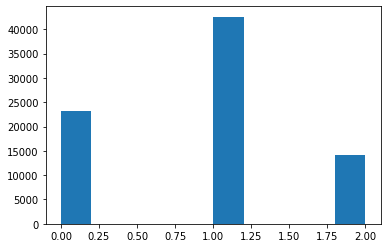

In [210]:
import matplotlib.pyplot as plt

plt.hist(y_train)